<h4>Importing necessary libraries</h4>

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
pd.set_option("display.max_rows",None)

<H4>Storing training data into a dataframe</h4>

In [42]:
## Storing training data into a dataframe.
train_data = pd.read_csv('train.csv')

<H1>Exploratory Data Analysis and Feature Engineering</H1>
<H4>Categorizing Different Features</H4><br/>
Features have been categorized into the following for convenience:<br/>

 - **categorical_features** - features with data type as Object<br/>
 - **categroical_features_nan** - categorical features with presence of invalid values<br/>
 - **temporal_features** - features that contained date or time, such as year.<br/>
 - **numerical_features** - features with numeric values<br/>

In [43]:
categorical_features = [feature for feature in train_data.columns if train_data[feature].dtypes == 'O']
categorical_features_nan = [feature for feature in train_data.columns if train_data[feature].dtypes == 'O'and train_data[feature].isnull().sum()>0]
temporal_features = [feature for feature in train_data.columns if 'Yr' in feature or 'Year' in feature]
numerical_features = [feature for feature in train_data.columns if train_data[feature].dtypes != 'O'and feature not in ['Id','SalePrice'] and feature not in temporal_features]

<h4>Heatmap to illustrate missing values in the overall dataset.</h4>

<Figure size 432x288 with 0 Axes>

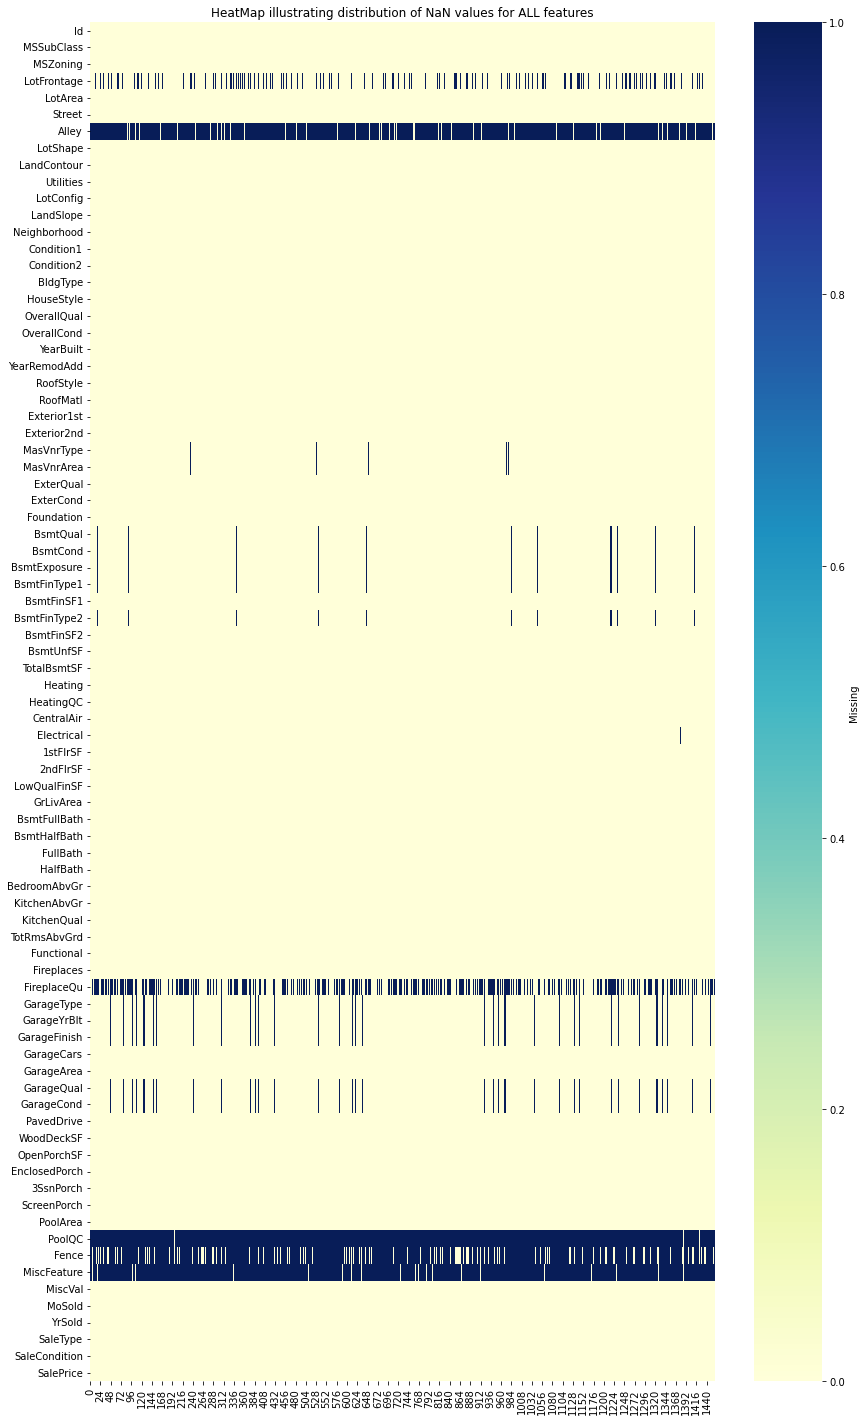

In [44]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.figure(figsize=(14,25))
plt.title('HeatMap illustrating distribution of NaN values for ALL features')
sns.heatmap(train_data.isnull().transpose(), cmap='YlGnBu', cbar_kws={'label': 'Missing'})
plt.show()

<h4>Imputation of Missing Values in Temporal Features</H4>

Only 'GarageYrBlt' feature has presence of invalid entries; therefore, relation of median SalePrice
with respect to both invalid and invalid entries in the feature was illustrated. Median SalePrice
with respect to invalid entries is lower than that of valid entries.

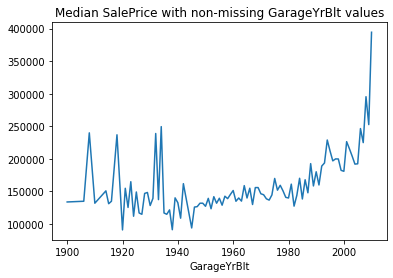

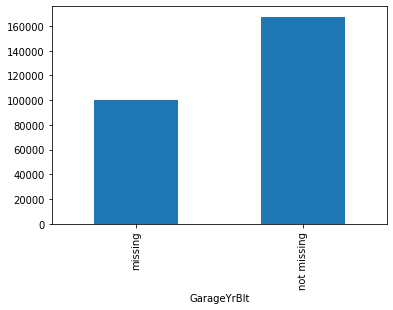

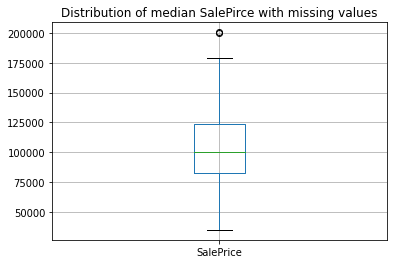

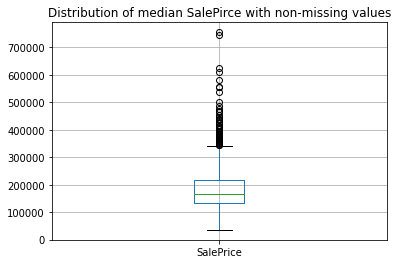

In [45]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
data = train_data.copy()
data[data['GarageYrBlt'].notnull()].groupby('GarageYrBlt')['SalePrice'].median().plot()
plt.title('Median SalePrice with non-missing GarageYrBlt values')
plt.show()
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
data['GarageYrBlt'] = np.where(data['GarageYrBlt'].isnull(),'missing','not missing')
data.groupby('GarageYrBlt')['SalePrice'].median().plot.bar()
plt.show()
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
df_missing = data[data['GarageYrBlt']=='missing'][['GarageYrBlt','SalePrice']]
df_missing.boxplot(column='SalePrice')
plt.title('Distribution of median SalePirce with missing values')
plt.show()
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
df_notmissing = data[data['GarageYrBlt']=='not missing'][['GarageYrBlt','SalePrice']]
df_notmissing.boxplot(column='SalePrice')
plt.title('Distribution of median SalePirce with non-missing values')
plt.show()

From above visualizations, mdeian SalePrice with missing values is around USD 100,000, which is lower
than the median SalePrice, at around USD 170,000, with non-missing values. An assumption can be made on the GarageYrBlt value for median SalePrice of USD 100,000 by observing the line chart that shows median SalePrice with respect to non-missing GarageYrBlt values. In that plot, the range of years 1920 to 1940 has closest correspondence with median SalePrice of USD 100,000. Therefore, with this assumption, all missing values can be replaced by the value 1930.

In [46]:
train_data['GarageYrBlt'] = np.where(train_data['GarageYrBlt'].isnull(),1930,train_data['GarageYrBlt'])

<H4>Transformation of Temporal Features</H4>

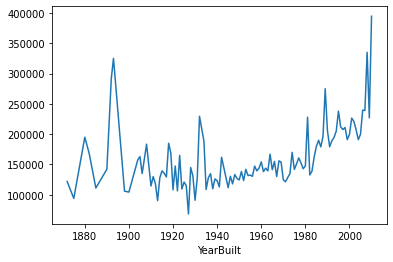

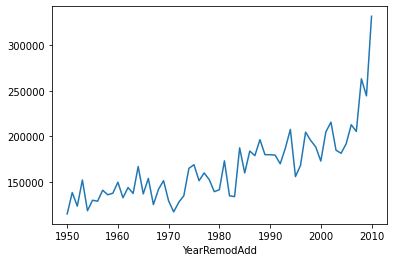

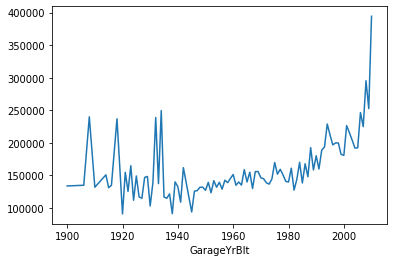

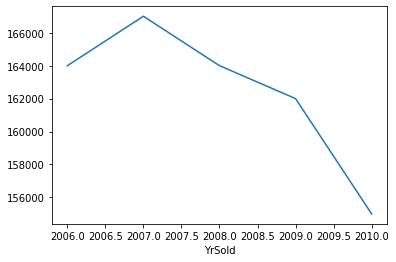

In [47]:

for feature in temporal_features:
    data = train_data.copy()
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    data.groupby(feature)['SalePrice'].median().plot()
    plt.show()

Year of build, remodelling, and garage build have positive trend with respect to sales price. However,
there is a negative trend of year sold with respect to sales price, which is unusual because a house's 
price should increase every year in a normal economy. This is occuring because the feature 'YrSold'
does not account for other three temporal features, as sales price at the year sold will depend on
how close build, remodelling and garage build took place relative to year sold.<br/><br/>
Therefore, all three temporal features, except 'YrSold', will be transformed by taking difference between the features with respect to year sold. After transformation of temporal features, the 'YrSold' feature will be dropped.

**Note:** In GarageYrBlt plot, there is a sharp dip at 1930, when compared to the same plot created when
analyzing missing values in GarageYrBlt. This is due to the replacement of missing values in this feature with 1930.

In [48]:
for feature in temporal_features:
    if feature == 'YrSold': pass
    else:
        train_data[feature] = train_data['YrSold'] - train_data[feature]

In [49]:
train_data = train_data.drop('YrSold', axis = 1)
temporal_features.remove('YrSold')

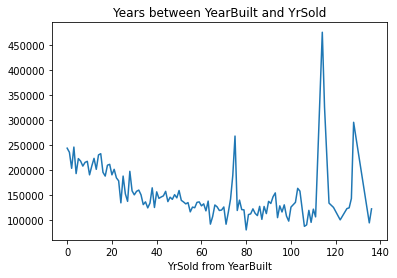

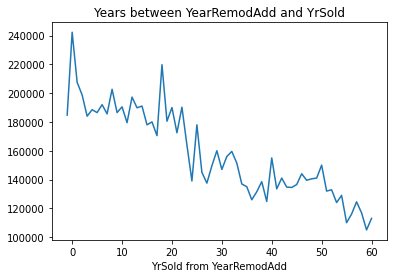

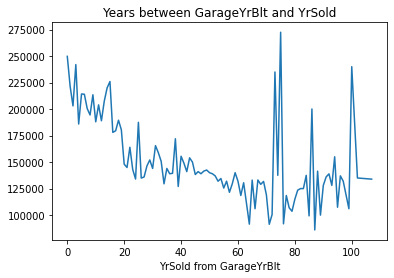

In [50]:
for feature in temporal_features:
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    data = train_data.copy()
    data.groupby(feature)['SalePrice'].median().plot()
    plt.xlabel('YrSold from '+feature)
    plt.title('Years between '+feature+' and YrSold')
    plt.show()

The above line charts indicate that recently built or remodeled houses have higher sales price.

<H4>Imputation of Missing Values in Numerical Features</H4>

Missing data in continuous numerical features were replaced by the mean value of the feature.
Assumption was made that a missing value in continuous numerical feature could be represented
by the mean value of its feature's non-missing values

In [51]:
for feature in numerical_features:
    train_data[feature] = np.where(train_data[feature].isnull(), train_data[feature].mean(),
                                   train_data[feature])

The heatmap illustrates remaining missing values after imputation of missing values in numerical features.

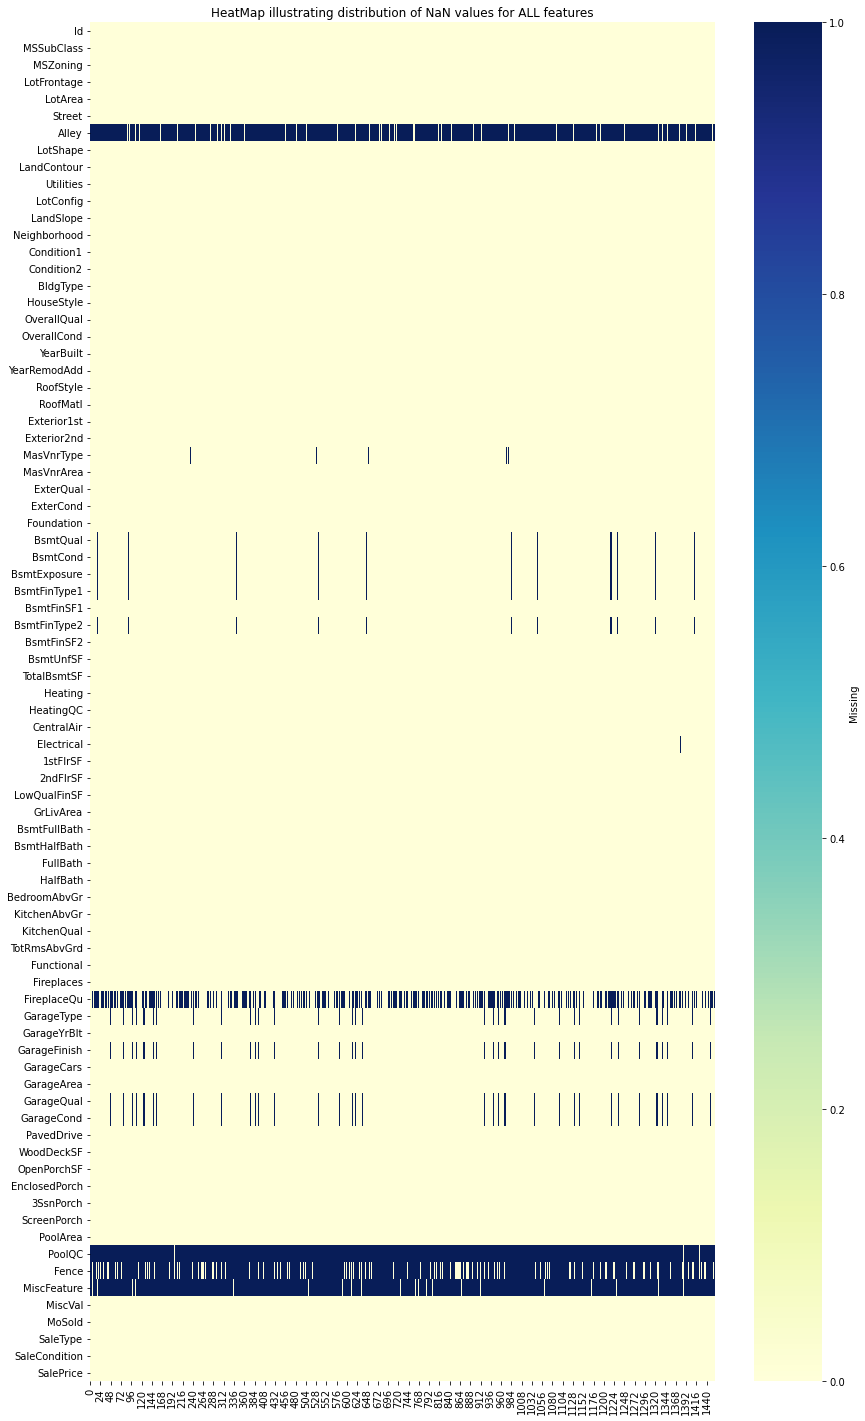

In [52]:
plt.figure(figsize=(14,25))
plt.title('HeatMap illustrating distribution of NaN values for ALL features')
sns.heatmap(train_data.isnull().transpose(), cmap='YlGnBu', cbar_kws={'label': 'Missing'})
plt.show()

<H4>Imputation of Missing Data in Categorical Features</H4></br>
Visualizing NaN values in categorical features with a heatmap and quantifying number of missing values in each categorical feature.

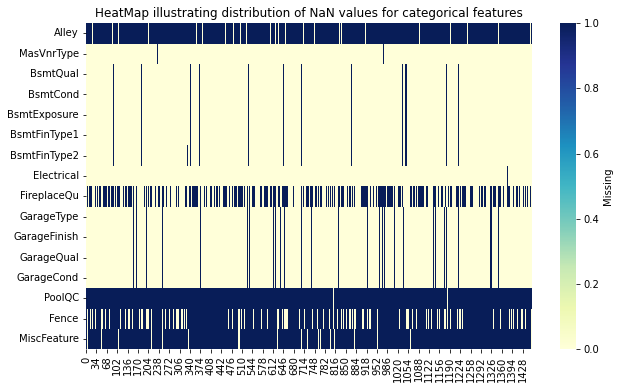

Respective % NaN values and # of unique values in Alley are 0.938 and 3
Respective % NaN values and # of unique values in MasVnrType are 0.005 and 5
Respective % NaN values and # of unique values in BsmtQual are 0.025 and 5
Respective % NaN values and # of unique values in BsmtCond are 0.025 and 5
Respective % NaN values and # of unique values in BsmtExposure are 0.026 and 5
Respective % NaN values and # of unique values in BsmtFinType1 are 0.025 and 7
Respective % NaN values and # of unique values in BsmtFinType2 are 0.026 and 7
Respective % NaN values and # of unique values in Electrical are 0.001 and 6
Respective % NaN values and # of unique values in FireplaceQu are 0.473 and 6
Respective % NaN values and # of unique values in GarageType are 0.055 and 7
Respective % NaN values and # of unique values in GarageFinish are 0.055 and 4
Respective % NaN values and # of unique values in GarageQual are 0.055 and 6
Respective % NaN values and # of unique values in GarageCond are 0.055 and 6

In [53]:
plt.figure(figsize=(10,6))
plt.title('HeatMap illustrating distribution of NaN values for categorical features')
sns.heatmap(train_data[categorical_features_nan].isnull().transpose(), cmap='YlGnBu', cbar_kws={'label': 'Missing'})
plt.show()

for feature in categorical_features_nan:
    data = train_data.copy()
    print('Respective % NaN values and # of unique values in '+feature+' are '+'{}'.format(np.round(data[feature].isnull().sum()/len(data),3))+' and '+'{}'.format(len(data[feature].unique())))

Categorical features containing more 40% of NaN values are dropped.
Rest of the categorical features with NaN values were recovered by replacing
them with the mode value.

In [54]:
train_data.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis=1,inplace=True)
categorical_features.remove('Alley')
categorical_features.remove('PoolQC')
categorical_features.remove('Fence')
categorical_features.remove('MiscFeature')
categorical_features.remove('FireplaceQu')

for feature in categorical_features:
    train_data[feature] = np.where(train_data[feature].isnull(), train_data[feature].mode(), train_data[feature])

<h4>Visualizing NaN values (if any) in overall training dataset using a heatmap.</h4>

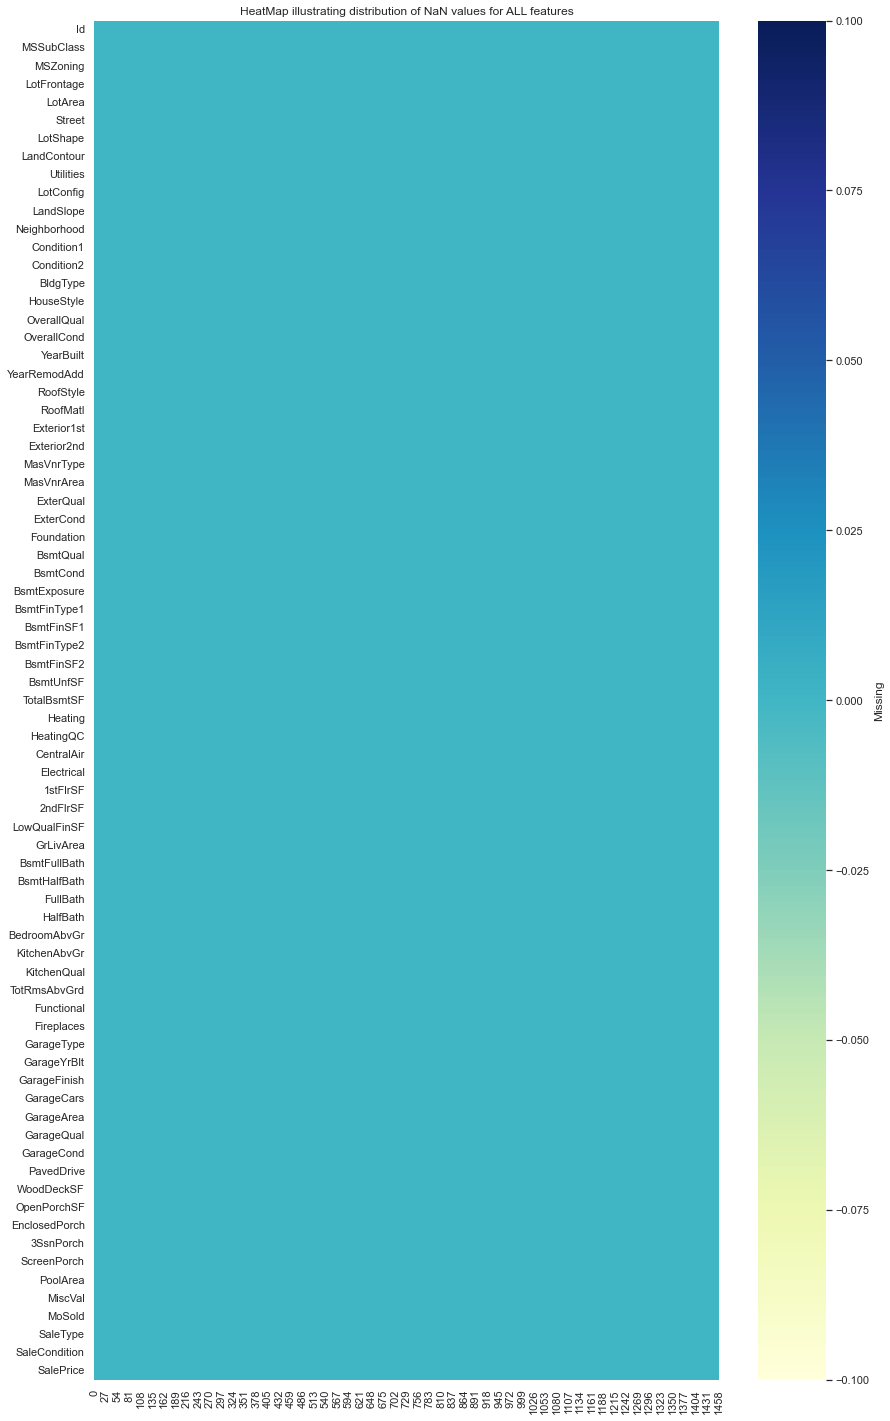

In [68]:
plt.figure(figsize=(14,25))
plt.title('HeatMap illustrating distribution of NaN values for ALL features')
sns.heatmap(train_data.isnull().transpose(), cmap='YlGnBu', cbar_kws={'label': 'Missing'})
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'cornflowerblue'})
plt.show()

<H4>Visualizing distribution of numerical features</H4>

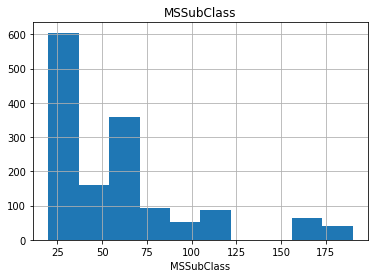

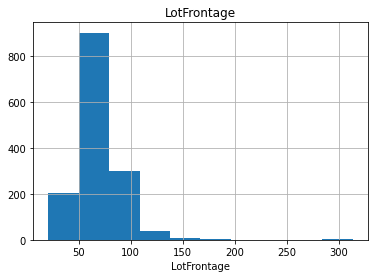

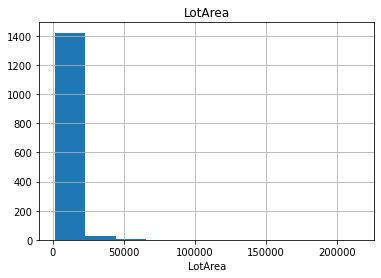

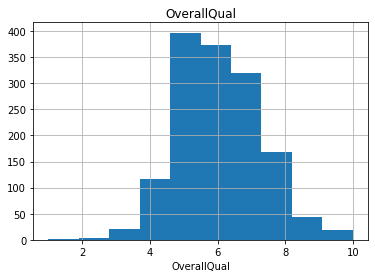

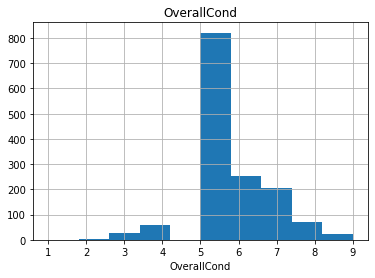

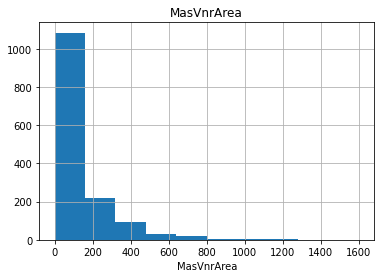

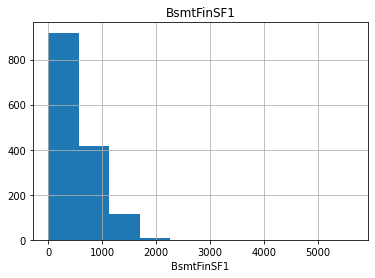

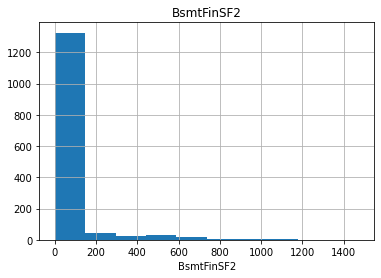

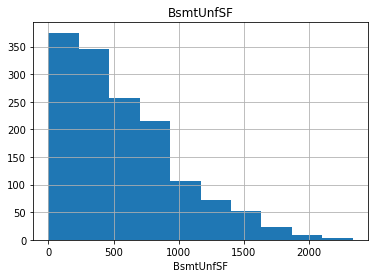

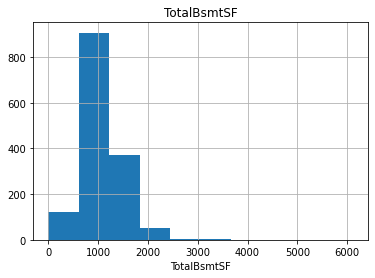

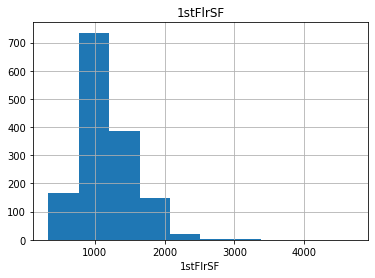

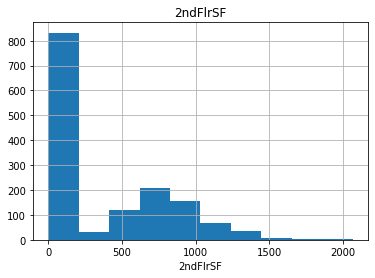

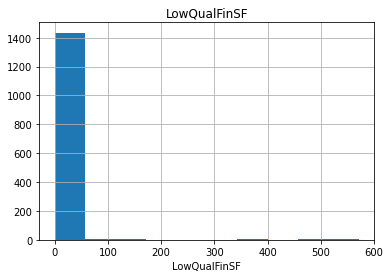

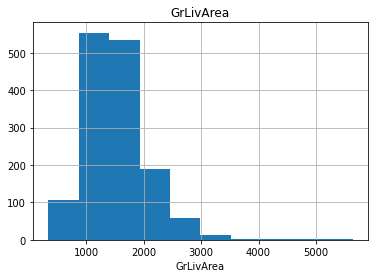

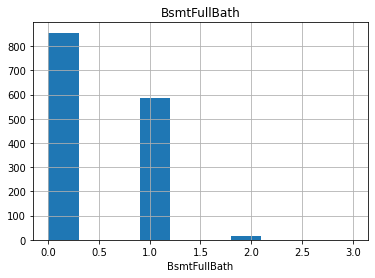

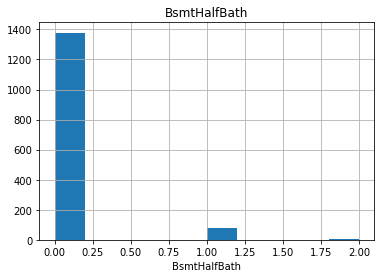

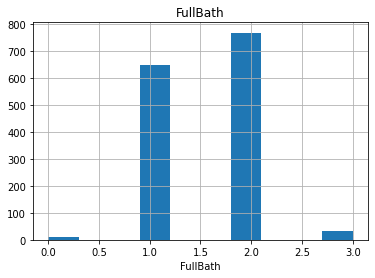

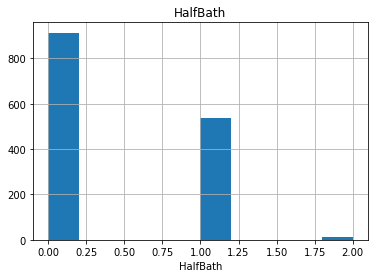

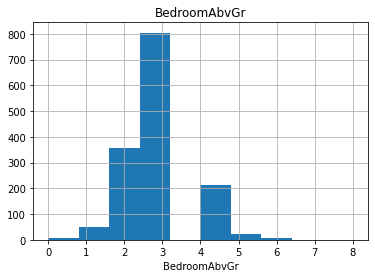

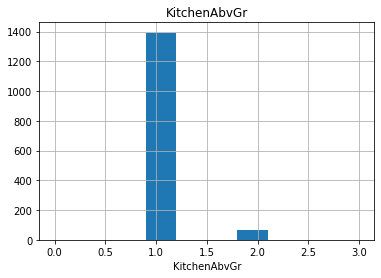

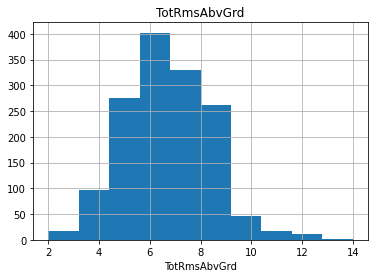

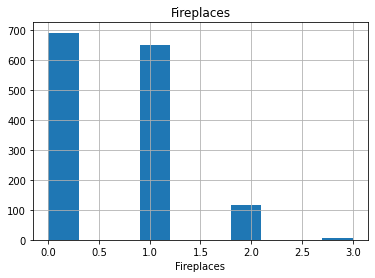

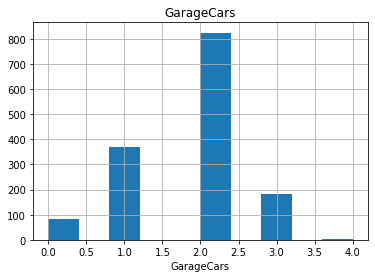

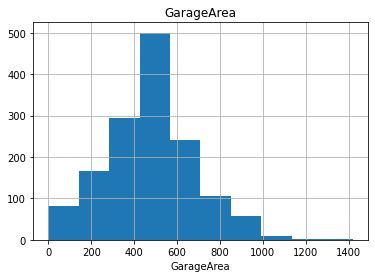

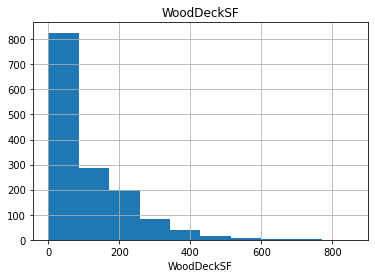

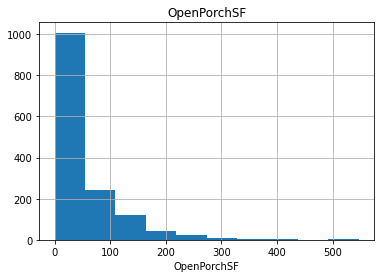

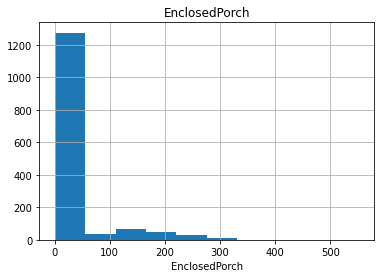

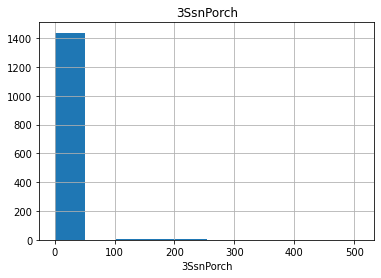

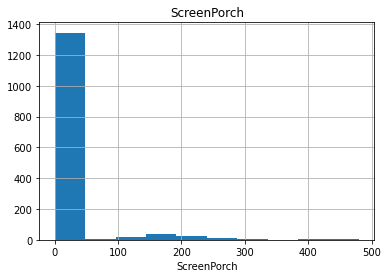

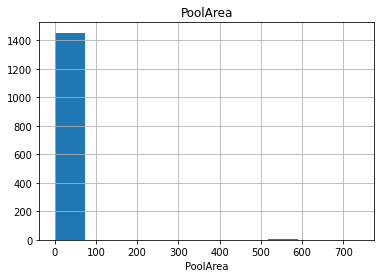

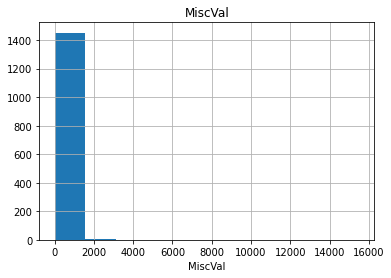

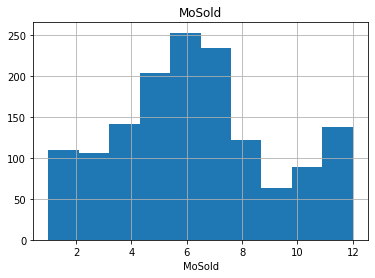

In [56]:
for feature in numerical_features:
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    data = train_data.copy()
    data[feature].hist()
    plt.title(feature)
    plt.xlabel(feature)
    plt.show()

<h4>Log Transformation on Skewed Features</h4></br>
As can be seen from above distributions, 'MSSubClass','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','WoodDeckSF','OpenPorchSF', and 'EnclosedPorch' features are positively skewed; therefore, natural log transformation was applied to transoform their distributions close to normal distribution.

In [57]:
numerical_features_skewed = ['MSSubClass','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','WoodDeckSF','OpenPorchSF','EnclosedPorch']
for feature in numerical_features_skewed:
        train_data[feature] = np.where(train_data[feature] == 0, train_data[feature], np.log(train_data[feature]))

C:\Users\Sajid Sarkar\OneDrive - MNSCU\Projects\2022_3_House Price Prediction Using Advanced Regression\house\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<H4>Performing standardization on numerical features</h4></br>
Although Random Forest Classifier will be used, features should still go through appropriate transoformation and scaling since it is a regression problem.

In [108]:
for feature in numerical_features:
    train_data[feature] = (train_data[feature] - train_data[feature].mean())/train_data[feature].std()

<h4>Performing similar data cleaning and transformations on testing data</h4>

In [109]:
test_data = pd.read_csv('test.csv')
categorical_features = [feature for feature in test_data.columns if test_data[feature].dtypes == 'O']
categorical_features_nan = [feature for feature in test_data.columns if test_data[feature].dtypes == 'O'and test_data[feature].isnull().sum()>0]
temporal_features = [feature for feature in test_data.columns if 'Yr' in feature or 'Year' in feature]
numerical_features = [feature for feature in test_data.columns if test_data[feature].dtypes != 'O'and feature not in ['Id','SalePrice'] and feature not in temporal_features]
test_data['GarageYrBlt'] = np.where(test_data['GarageYrBlt'].isnull(),1930,test_data['GarageYrBlt'])
for feature in temporal_features:
    if feature == 'YrSold': pass
    else:
        test_data[feature] = test_data['YrSold'] - test_data[feature]
        
test_data = test_data.drop('YrSold', axis = 1)
temporal_features.remove('YrSold')
for feature in numerical_features:
    test_data[feature] = np.where(test_data[feature].isnull(), test_data[feature].mean(),
                                   test_data[feature])
test_data.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis=1,inplace=True)
categorical_features.remove('Alley')
categorical_features.remove('PoolQC')
categorical_features.remove('Fence')
categorical_features.remove('MiscFeature')
categorical_features.remove('FireplaceQu')

for feature in categorical_features:
    test_data[feature] = np.where(test_data[feature].isnull(), test_data[feature].mode(), test_data[feature])

numerical_features_skewed = ['MSSubClass','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','WoodDeckSF','OpenPorchSF','EnclosedPorch']
for feature in numerical_features_skewed:
        test_data[feature] = np.where(test_data[feature] == 0, test_data[feature], np.log(test_data[feature]))
for feature in numerical_features:
    test_data[feature] = (test_data[feature] - test_data[feature].mean())/test_data[feature].std()
test_id = test_data['Id']
x_test = test_data.drop('Id',axis=1)

C:\Users\Sajid Sarkar\OneDrive - MNSCU\Projects\2022_3_House Price Prediction Using Advanced Regression\house\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<H1>Training and Prediction Using Random Forest Classifier</H1>

<H4>Preparing training and test data and assinging dummy values to categorical features</H4></br>
Both x test and x train datasets were combined for creating dummy variables. This was to ensure both test and train datasets contained exact features after applying "pd.get_dummies" function. This can occur when a categorical feature in train set has different categories inside it when compared to the same feature in test set.

In [111]:
x_train = train_data.drop(['Id','SalePrice'],axis=1)
y_train = train_data['SalePrice']
x_train['train'] = 1
x_test['train'] = 0
combined = pd.concat([x_train, x_test])
dummies = pd.get_dummies(combined[categorical_features], prefix='dummy')
combined.drop(categorical_features,axis=1,inplace=True)
combined = pd.concat([combined,dummies],axis=1)
x_train = combined[combined['train']==1]
x_test = combined[combined['train']==0]

<H4>Using RandomForestClassifier to predict SalePrice</H4>

In [112]:
model = RandomForestClassifier(n_estimators=2000)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
y_predict = pd.DataFrame(y_predict, columns=['SalePrice'])
y_predict.insert(0,'Id',test_id)

In [113]:
y_predict.to_csv('submission.csv',index=False)